# Vision Transformer / ViT

---

This code demonstrates the implementation of a Vision Transformer (ViT), structured into several blocks, each addressing different aspects of the model and data preparation. Here's an overview of each part:

**Environment Setup**: The script begins by ensuring that the required versions of `torch` and `torchvision` are installed. If not, the script installs the necessary nightly versions to meet the version requirements for the APIs used.

**Imports**: Following the environment setup, necessary libraries are imported, including `matplotlib` for plotting, `torch` and `torchvision` for building and training the model, and utility functions from a custom `going_modular` module.

**Data Preparation**: The data pipeline is set up by downloading a dataset of images (pizza, steak, and sushi) and setting up directory paths for training and testing images. `torchvision.transforms` is used to create image transformations and set up data loaders for batching the images.

**Image Visualization and Patching**: Before diving into the ViT model, a sample image is visualized and split into patches. This step includes creating a convolutional layer to transform the image into patches, flattening these patches, and ensuring they are in the correct shape for the model.

**Patch Embedding Layer**: The patching process is encapsulated into a `PatchEmbedding` class, which turns a 2D image into a 1D sequence of embeddings. This class uses a convolutional layer followed by a flattening operation.

**Class Token and Position Embedding**: A class token is added to the sequence of patch embeddings, and a learnable position embedding is created to retain the positional information of the patches.

**Multi-Head Self-Attention (MSA) Block**: The `MultiheadSelfAttentionBlock` class implements the self-attention mechanism, crucial for capturing the relationships between different parts of the image.

**MLP Block**: The `MLPBlock` class implements a multi-layer perceptron, used for further processing the output from the self-attention block.

**Transformer Encoder Block**: The MSA and MLP blocks are combined into a `TransformerEncoderBlock` class, forming the building block of the Transformer architecture.

**Vision Transformer (ViT) Model**: Finally, everything is put together into a `ViT` class. This class uses multiple transformer encoder blocks and includes the full ViT architecture, complete with the embedding and position encoding layers.

This code provides a comprehensive implementation of a Vision Transformer, covering data preparation, patching, and the full model architecture.

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    
    # Check if torch version is at least 1.12
    assert int(torch.__version__.split('.')[1]) >= 12, 'torch version should be 1.12+'
    
    # Check if torchvision version is at least 0.13
    assert int(torchvision.__version__.split('.')[1]) >= 13, 'torchvision version should be 0.13+'
    
    # If versions are sufficient, print them
    print(f'torch version: {torch.__version__}')
    print(f'torchvision version: {torchvision.__version__}')

except AssertionError as e:
    print(f'[INFO] {e}, installing nightly versions.')
    
    # Install nightly versions of torch, torchvision, and torchaudio
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    
    # Import again after installation
    import torch
    import torchvision
    
    # Print the versions after installation
    print(f'torch version: {torch.__version__}')
    print(f'torchvision version: {torchvision.__version__}')

except ImportError:
    print('[INFO] torch/torchvision not found, installing nightly versions.')
    
    # Install nightly versions if torch or torchvision is not found
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    
    # Import after installation
    import torch
    import torchvision
    
    # Print versions after installation
    print(f'torch version: {torch.__version__}')
    print(f'torchvision version: {torchvision.__version__}')

except Exception as e:
    print(f'[ERROR] Failed to check/install torch/torchvision: {e}')


[INFO] torch version should be 1.12+, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.2.2
torchvision version: 0.17.2


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except ImportError:
    print('[INFO] Could not find torchinfo... installing it.')
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except ImportError:
    # Get the going_modular scripts
    print('[INFO] Could not find going_modular or helper_functions scripts... downloading them from GitHub.')
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


/Users/vadimsuharev/miniforge3/envs/ViT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

#### Get data

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                           destination='pizza_steak_sushi')
image_path


[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [7]:
## Create Transforms
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224  # comes from Tables 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Create a batch size (32, the paper uses 4096)
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
len(train_dataloader), len(test_dataloader), class_names


(8, 3, ['pizza', 'steak', 'sushi'])

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label


(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

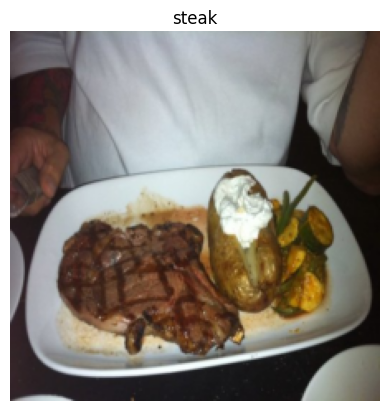

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

#### Split data into patches and creating the class, position and patch embedding

In [11]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches N
number_of_patches = int((height * width) / patch_size**2)
number_of_patches


196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 \
    * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D image): {embedding_layer_output_shape}')


Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D image): (196, 768)


#### Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

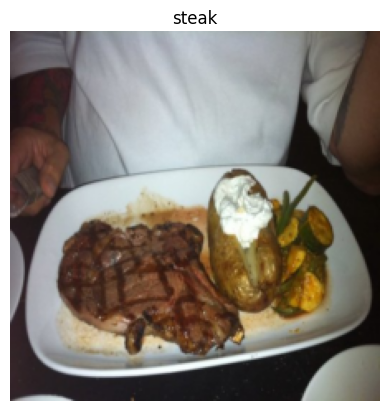

In [13]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)


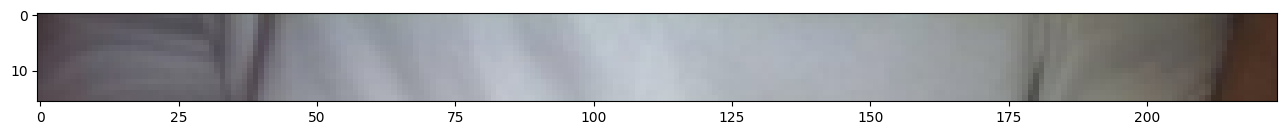

In [14]:
# Get the top row of pixels
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])


Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


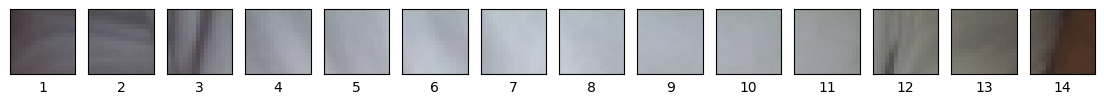

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


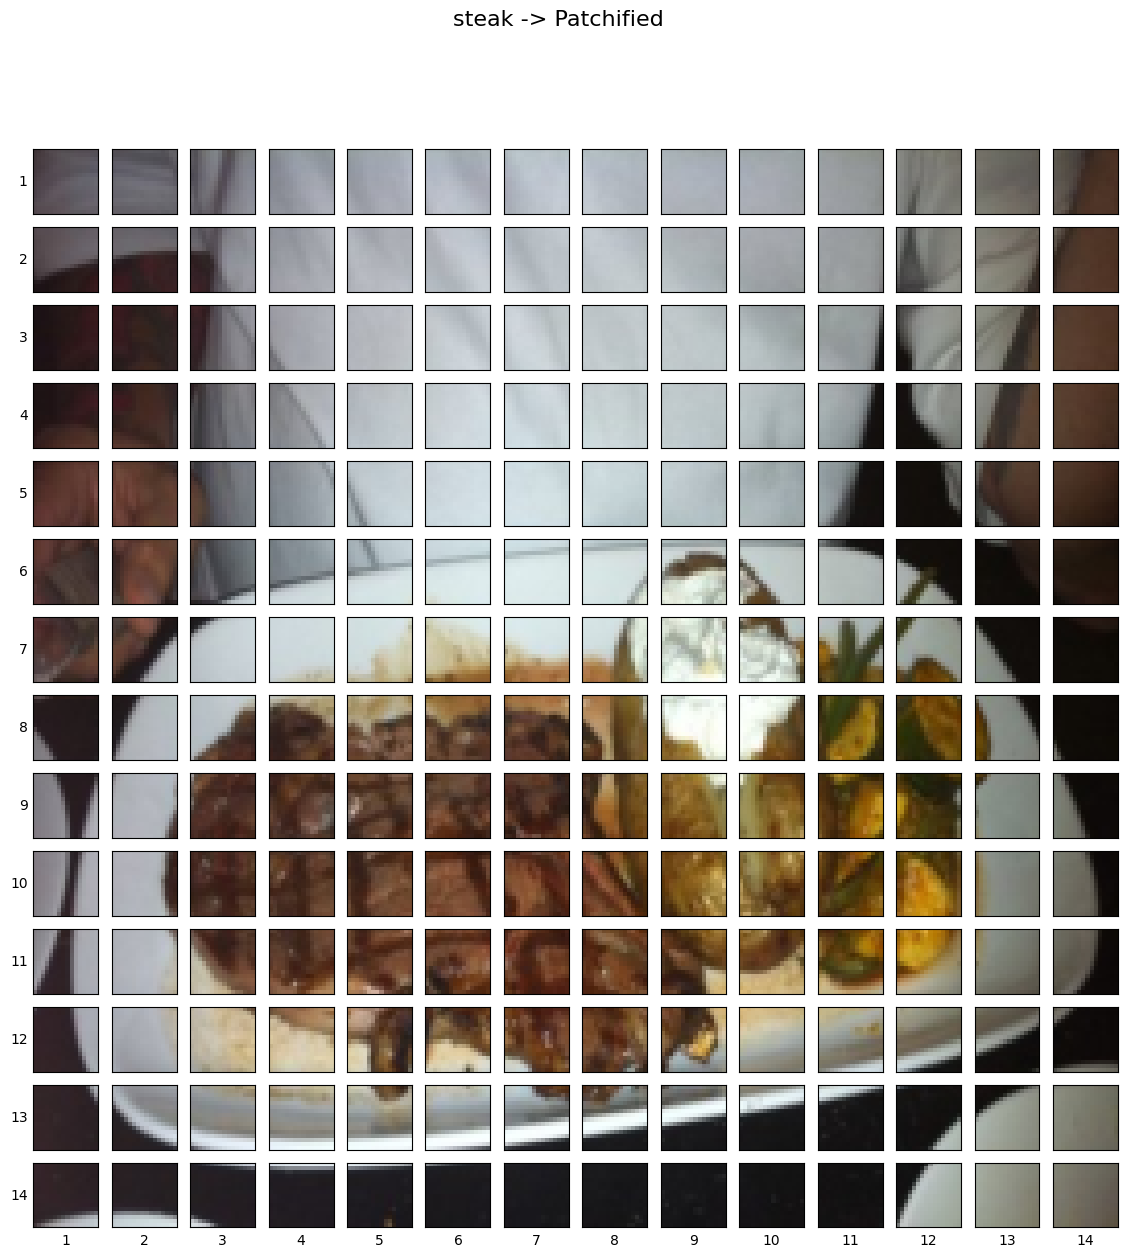

In [16]:
# Setup code to plot whole image as patches
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'
print(f'Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation='horizontal',
                             horizontalalignment='right',
                             verticalalignment='center')
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f'{class_names[label]} -> Patchified', fontsize=16)
plt.show()



In [17]:
# Create conv2d layer to turn image into patches / embeddings
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,  # 16*16*3
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

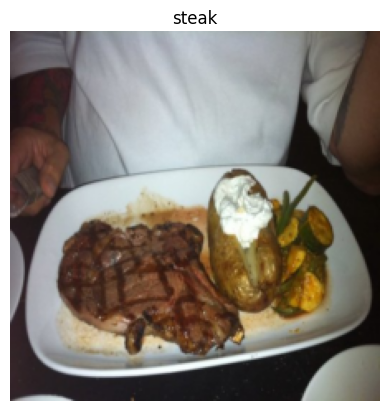

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [19]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)


torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [161, 461, 663, 720, 480]


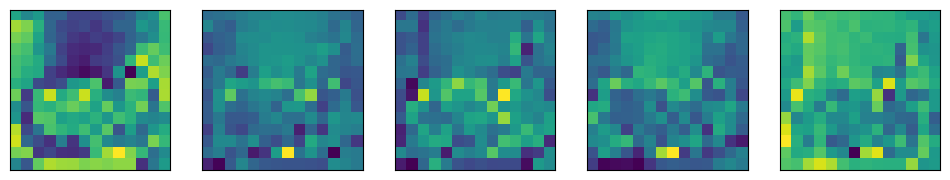

In [20]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f'Showing random convolutional feature maps from indexes: {random_indexes}')

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);


In [21]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad


(tensor([[[-0.0362, -0.0623, -0.0255, -0.0627, -0.0793, -0.1036, -0.0641,
           -0.1022, -0.0881, -0.0817, -0.0509, -0.0291,  0.0004,  0.0215],
          [-0.0139,  0.0490,  0.0412, -0.0768, -0.0935, -0.0761, -0.0929,
           -0.0703, -0.0831, -0.0629, -0.0381,  0.0154,  0.0559,  0.0937],
          [ 0.0279,  0.0242,  0.0040, -0.0449, -0.0776, -0.0986, -0.0737,
           -0.0830, -0.0727, -0.1061,  0.0545,  0.0785,  0.0075,  0.0538],
          [ 0.0193,  0.0234, -0.0362, -0.0743, -0.0848, -0.0937, -0.1122,
           -0.0876, -0.0762, -0.0570, -0.0559,  0.0369,  0.0252,  0.0609],
          [ 0.0176,  0.0234, -0.0270, -0.0704, -0.0301, -0.0991, -0.0920,
           -0.0872, -0.0692, -0.0806, -0.0207,  0.0512,  0.0718,  0.0748],
          [ 0.0355,  0.1034, -0.0648, -0.0637, -0.0800, -0.0859, -0.1125,
           -0.1225,  0.0603, -0.1685, -0.0916, -0.2197,  0.0569,  0.0638],
          [ 0.0196,  0.0703, -0.2566, -0.0760, -0.0284,  0.0573,  0.0970,
            0.0772,  0.0574, -0.

### Flattening the patch embedding

In [22]:
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [23]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,  # torch.Size([1, 768, 14, 14]) flatten 14, 14
                           end_dim=3)

flatten_layer(image_out_of_conv).shape


torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


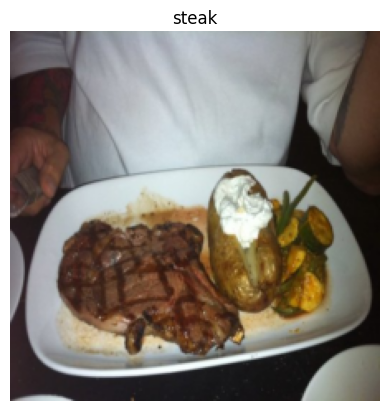

In [24]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f'Original image shape: {image.shape}')

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f'Image feature map shape: {image_out_of_conv.shape}')

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')


In [25]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)

print(f'Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]')


Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


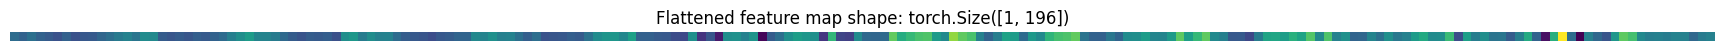

In [26]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False);


In [27]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape


(tensor([[-0.0362, -0.0623, -0.0255, -0.0627, -0.0793, -0.1036, -0.0641, -0.1022,
          -0.0881, -0.0817, -0.0509, -0.0291,  0.0004,  0.0215, -0.0139,  0.0490,
           0.0412, -0.0768, -0.0935, -0.0761, -0.0929, -0.0703, -0.0831, -0.0629,
          -0.0381,  0.0154,  0.0559,  0.0937,  0.0279,  0.0242,  0.0040, -0.0449,
          -0.0776, -0.0986, -0.0737, -0.0830, -0.0727, -0.1061,  0.0545,  0.0785,
           0.0075,  0.0538,  0.0193,  0.0234, -0.0362, -0.0743, -0.0848, -0.0937,
          -0.1122, -0.0876, -0.0762, -0.0570, -0.0559,  0.0369,  0.0252,  0.0609,
           0.0176,  0.0234, -0.0270, -0.0704, -0.0301, -0.0991, -0.0920, -0.0872,
          -0.0692, -0.0806, -0.0207,  0.0512,  0.0718,  0.0748,  0.0355,  0.1034,
          -0.0648, -0.0637, -0.0800, -0.0859, -0.1125, -0.1225,  0.0603, -0.1685,
          -0.0916, -0.2197,  0.0569,  0.0638,  0.0196,  0.0703, -0.2566, -0.0760,
          -0.0284,  0.0573,  0.0970,  0.0772,  0.0574, -0.1640,  0.1643, -0.1302,
          -0.144

## Turning the ViT patch embedding layer into a PyTorch module

In [28]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    '''Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    '''
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f'Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}'

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]



In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f'Input image shape: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f'Output patch embedding shape: {patch_embedded_image.shape}')


Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [30]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for 'random_input_image_error'
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [31]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f'Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]')


tensor([[[-0.4136,  0.1046, -0.1341,  ...,  0.2863, -0.1301,  0.1186],
         [-0.4317,  0.1226, -0.1467,  ...,  0.3084, -0.1558,  0.1433],
         [-0.5552,  0.1298, -0.1750,  ...,  0.3376, -0.1633,  0.1553],
         ...,
         [-0.8194,  0.3092, -0.2428,  ...,  0.5624, -0.0786,  0.0780],
         [-0.5352,  0.1031, -0.1549,  ...,  0.4265, -0.2858,  0.2414],
         [-0.4103,  0.0678, -0.1135,  ...,  0.3068, -0.2187,  0.1868]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [32]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f'Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]')


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [33]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f'Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]')


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4136,  0.1046, -0.1341,  ...,  0.2863, -0.1301,  0.1186],
         [-0.4317,  0.1226, -0.1467,  ...,  0.3084, -0.1558,  0.1433],
         ...,
         [-0.8194,  0.3092, -0.2428,  ...,  0.5624, -0.0786,  0.0780],
         [-0.5352,  0.1031, -0.1549,  ...,  0.4265, -0.2858,  0.2414],
         [-0.4103,  0.0678, -0.1135,  ...,  0.3068, -0.2187,  0.1868]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Creating the position embedding

In [34]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4136,  0.1046, -0.1341,  ...,  0.2863, -0.1301,  0.1186],
          [-0.4317,  0.1226, -0.1467,  ...,  0.3084, -0.1558,  0.1433],
          ...,
          [-0.8194,  0.3092, -0.2428,  ...,  0.5624, -0.0786,  0.0780],
          [-0.5352,  0.1031, -0.1549,  ...,  0.4265, -0.2858,  0.2414],
          [-0.4103,  0.0678, -0.1135,  ...,  0.3068, -0.2187,  0.1868]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f'Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]')


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## Putting it all together: from image to embedding

In [36]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f'Input image with batch dimension shape: {x.shape}')

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f'Patching embedding shape: {patch_embedding.shape}')

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f'Class token embedding shape: {class_token.shape}')

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## MSA Block

In [37]:
class MultiheadSelfAttentionBlock(nn.Module):
    '''Creates a multi-head self-attention block'''
    def __init__(
        self,
        embedding_dim:int=768,
        num_heads:int=12,
        attn_dropout:int=0):

        super().__init__()

        # Create the norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create multihead attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)  # (batch, seq, feature) -> (batch, num_patches, embedding_dimension)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,
            key=x,
            value=x,
            need_weights=False)
        return attn_output

In [38]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(
    embedding_dim=768, num_heads=12)
# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output shape MSA block: {patched_image_through_msa_block.shape}')


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## MLP Block

In [39]:
class MLPBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                mlp_size:int=3072,
                dropout:int=0.1):
        super().__init__()

        # Create the norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x


In [40]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

## Transformer Encoder

In [41]:
class TransformerEncoderBlock(nn.Module):
    def __init__(
        self,
        embedding_dim:int=768,
        num_heads:int=12,
        mlp_size:int=3072,
        mlp_dropout:int=0.1,
        attn_dropout:int=0):
        super().__init__()

        # MSA block
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout)

        # MLP block
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x  # residual connection
        x = self.mlp_block(x) + x
        return x



In [42]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Summary / torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),  # batch_size, number_of_patches, embedding_dimension
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])



Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Create a Transformer Encoder layer with PyTorch layers

In [43]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation='gelu',
    batch_first=True,
    norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [44]:
# Summary / torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),  # batch_size, number_of_patches, embedding_dimension
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Create ViT

In [45]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    '''Creates a Vision Transformer architecture with ViT-Base hyperparameters by default.'''

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f'Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}.'

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim),
            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches+1, embedding_dim),
            requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,                                      num_heads=num_heads,                                                   mlp_size=mlp_size,                                                     mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes))

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # 14. Create patch embedding
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding
        x = self.position_embedding + x

        # 17. Run embedding dropout
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [46]:
batch_size = 32
embedding_dim = 768
class_embedding = nn.Parameter(
    data=torch.randn(1, 1, embedding_dim),
    requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)


torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [47]:
vit = ViT()
vit


ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

### Setting up training code

In [48]:
# Creating an optimizer
optimizer = torch.optim.Adam(
    vit.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=0.1)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=5,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device)


 20%|██        | 1/5 [03:23<13:34, 203.65s/it]

Epoch: 1 | train_loss: 3.0880 | train_acc: 0.2578 | test_loss: 2.1742 | test_acc: 0.2604


 40%|████      | 2/5 [06:24<09:30, 190.09s/it]

Epoch: 2 | train_loss: 2.0581 | train_acc: 0.2227 | test_loss: 1.3802 | test_acc: 0.1979


 60%|██████    | 3/5 [09:23<06:10, 185.11s/it]

Epoch: 3 | train_loss: 1.2789 | train_acc: 0.4219 | test_loss: 2.2740 | test_acc: 0.1979


 80%|████████  | 4/5 [12:19<03:01, 181.43s/it]

Epoch: 4 | train_loss: 1.5764 | train_acc: 0.2734 | test_loss: 2.9003 | test_acc: 0.1979


100%|██████████| 5/5 [15:20<00:00, 184.14s/it]

Epoch: 5 | train_loss: 1.6476 | train_acc: 0.4219 | test_loss: 2.1621 | test_acc: 0.2604


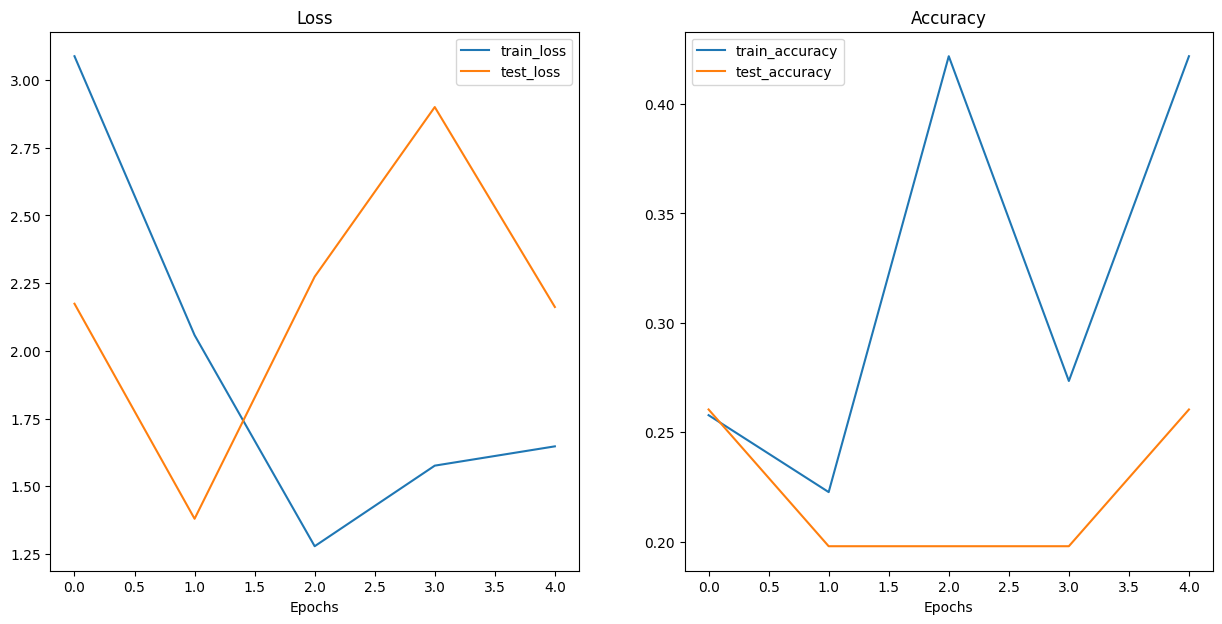

In [49]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)


The model is underfitting and overfitting

# Pretrained ViT / torch.models

In [50]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device=device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)



In [51]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Preparing data for ViT


In [52]:
# Get automatic transforms for ViT
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [53]:
train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [54]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir= test_dir,
    transform=vit_transforms,
    batch_size=32)


### Train ViT

In [55]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier
set_seeds()
results = pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)


 20%|██        | 1/5 [01:40<06:40, 100.10s/it]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769


 40%|████      | 2/5 [03:20<05:00, 100.29s/it]

Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977


 60%|██████    | 3/5 [04:57<03:17, 98.83s/it] 

Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186


 80%|████████  | 4/5 [06:36<01:38, 98.94s/it]

Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186


100%|██████████| 5/5 [08:18<00:00, 99.60s/it]

Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977


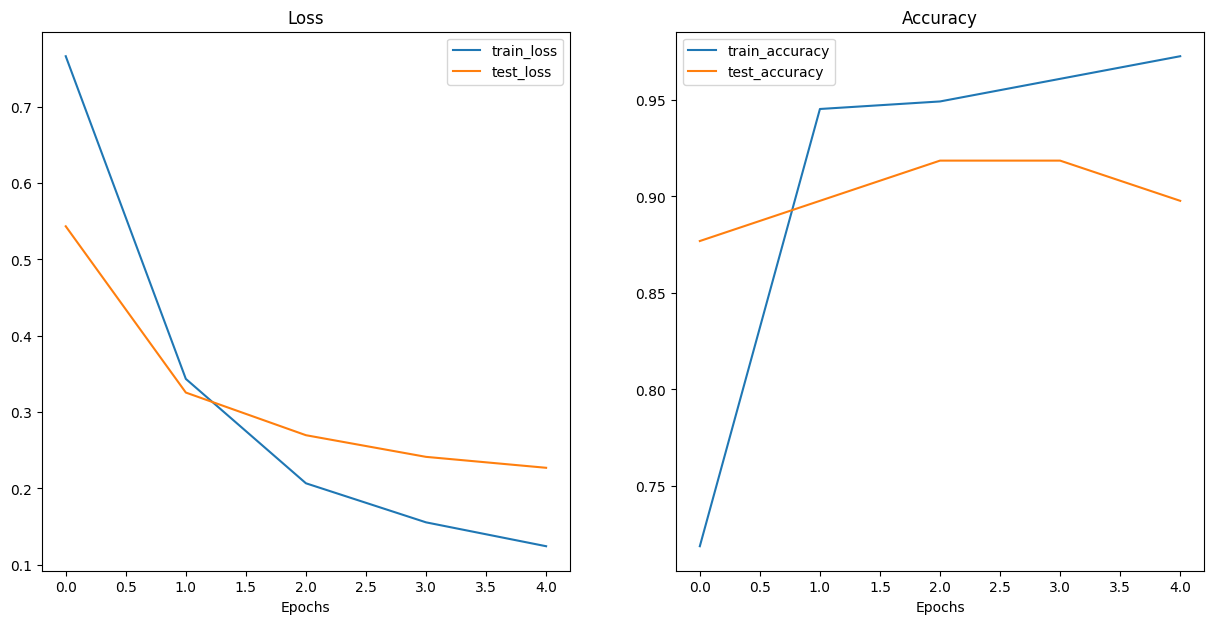

In [56]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)


### Save the model

In [57]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir='models',
                 model_name='pretrained_vit.pth')

[INFO] Saving model to: models/pretrained_vit.pth


In [58]:
from pathlib import Path

#Get the model size
model_size = Path('models/pretrained_vit.pth').stat().st_size // (1021*1024)
print(f'Model size {model_size} MB')


Model size 328 MB
